# Argo Data
Here both BGC and Standard Argo data is downlaoded quality checked and plotted for both Basins

In [44]:
# Immporting Labriaries
# If not available, install using pip install <package-name>

# Import packages
import numpy as np
import pandas as pd
from scipy import interpolate
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import requests
import time
import os
import urllib3
import shutil
import plotly.graph_objs as go
import cmocean

## Downloading  Argo Data
Here argo data is downloaded to a specific directory

In [45]:
# Base filepath
root = '../data/GO-BGC Workshop/'
profile_dir = root + 'Profiles/'

# Create GO-BGC folders if they do not exist yet
if 'GO-BGC Workshop' not in os.listdir('../data/'):
  os.mkdir(root)
if 'Profiles' not in os.listdir(root):
  os.mkdir(profile_dir)

In [46]:
# Function to download a single file
def download_file(url_path,filename,save_to=None,overwrite=False,verbose=True):
    """ Downloads and saves a file from a given URL using HTTP protocol.

    Note: If '404 file not found' error returned, function will return without downloading anything.
    
    Arguments:
        url_path: root URL to download from including trailing slash ('/')
        filename: filename to download including suffix
        save_to: None (to download to root Google Drive GO-BGC directory)
                 or directory path
        overwrite: False to leave existing files in place
                   or True to overwrite existing files
        verbose: True to announce progress
                 or False to stay silent
    
    """
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    if save_to is None:
      save_to = root

    try:
      if filename in os.listdir(save_to):
          if not overwrite:
              if verbose: print('>>> File ' + filename + ' already exists. Leaving current version.')
              return
          else:
              if verbose: print('>>> File ' + filename + ' already exists. Overwriting with new version.')

      def get_func(url,stream=True):
          try:
              return requests.get(url,stream=stream,auth=None,verify=False)
          except requests.exceptions.ConnectionError as error_tag:
              print('Error connecting:',error_tag)
              time.sleep(1)
              return get_func(url,stream=stream)

      response = get_func(url_path + filename,stream=True)

      if response.status_code == 404:
          if verbose: print('>>> File ' + filename + ' returned 404 error during download.')
          return
      with open(save_to + filename,'wb') as out_file:
          shutil.copyfileobj(response.raw,out_file)
      del response
      if verbose: print('>>> Successfully downloaded ' + filename + '.')

    except:
      if verbose: print('>>> An error occurred while trying to download ' + filename + '.')

In [47]:
# Function to download and parse GDAC synthetic profile index file
def argo_gdac(lat_range=None,lon_range=None,start_date=None,end_date=None,sensors=None,floats=None,
              overwrite_index=False,overwrite_profiles=False,skip_download=False,
              download_individual_profs=False,save_to=None,verbose=True):
  """ Downloads GDAC Sprof index file, then selects float profiles based on criteria.
      Either returns information on profiles and floats (if skip_download=True) or downloads them (if False).

      Arguments:
          lat_range: None, to select all latitudes
                     or [lower, upper] within -90 to 90 (selection is inclusive)
          lon_range: None, to select all longitudes
                     or [lower, upper] within either -180 to 180 or 0 to 360 (selection is inclusive)
                     NOTE: longitude range is allowed to cross -180/180 or 0/360
          start_date: None or datetime object
          end_date:   None or datetime object
          sensors: None, to select profiles with any combination of sensors
                   or string or list of strings to specify required sensors
                   > note that common options include PRES, TEMP, PSAL, DOXY, CHLA, BBP700,
                                                      PH_IN_SITU_TOTAL, and NITRATE
          floats: None, to select any floats matching other criteria
                  or int or list of ints specifying floats' WMOID numbers
          overwrite_index: False to keep existing downloaded GDAC index file, or True to download new index
          overwrite_profiles: False to keep existing downloaded profile files, or True to download new files
          skip_download: True to skip download and return: (<list of WMOIDs>, <DataFrame of index file subset>,
                                                            <list of downloaded filenames [if applicable]>)
                         or False to download those profiles
          download_individual_profs: False to download single Sprof file containing all profiles for each float
                                     or True to download individual profile files for each float
          save_to: None to download to Google Drive "/GO-BGC Workshop/Profiles" directory
                   or string to specify directory path for profile downloads
          verbose: True to announce progress, or False to stay silent

  """
  # Paths
  url_root = 'https://www.usgodae.org/ftp/outgoing/argo/'
  dac_url_root = url_root + 'dac/'
  index_filename = 'argo_synthetic-profile_index.txt'
  if save_to is None: save_to = root

  # Download GDAC synthetic profile index file
  download_file(url_root,index_filename,overwrite=overwrite_index)

  # Load index file into Pandas DataFrame
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],
                          date_parser=lambda x: pd.to_datetime(x,format='%Y%m%d%H%M%S'))

  # Establish time and space criteria
  if lat_range is None:  lat_range = [-90.0,90.0]
  if lon_range is None:  lon_range = [-180.0,180.0]
  elif lon_range[0] > 180 or lon_range[1] > 180:
    if lon_range[0] > 180: lon_range[0] -= 360
    if lon_range[1] > 180: lon_range[1] -= 360
  if start_date is None: start_date = datetime(1900,1,1)
  if end_date is None:   end_date = datetime(2200,1,1)

  float_wmoid_regexp = r'[a-z]*/[0-9]*/profiles/[A-Z]*([0-9]*)_[0-9]*[A-Z]*.nc'
  gdac_index['wmoid'] = gdac_index['file'].str.extract(float_wmoid_regexp).astype(int)
  filepath_main_regexp = '([a-z]*/[0-9]*/)profiles/[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath_main'] = gdac_index['file'].str.extract(filepath_main_regexp)
  filepath_regexp = '([a-z]*/[0-9]*/profiles/)[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath'] = gdac_index['file'].str.extract(filepath_regexp)
  filename_regexp = '[a-z]*/[0-9]*/profiles/([A-Z]*[0-9]*_[0-9]*[A-Z]*.nc)'
  gdac_index['filename'] = gdac_index['file'].str.extract(filename_regexp)

  # Subset profiles based on time and space criteria
  gdac_index_subset = gdac_index.loc[np.logical_and.reduce([gdac_index['latitude'] >= lat_range[0],
                                                            gdac_index['latitude'] <= lat_range[1],
                                                            gdac_index['date'] >= start_date,
                                                            gdac_index['date'] <= end_date]),:]
  if lon_range[1] >= lon_range[0]:    # range does not cross -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_and(gdac_index_subset['longitude'] >= lon_range[0],
                                                             gdac_index_subset['longitude'] <= lon_range[1])]
  elif lon_range[1] < lon_range[0]:   # range crosses -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_or(gdac_index_subset['longitude'] >= lon_range[0],
                                                            gdac_index_subset['longitude'] <= lon_range[1])]

  # If requested, subset profiles using float WMOID criteria
  if floats is not None:
    if type(floats) is not list: floats = [floats]
    gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['wmoid'].isin(floats),:]

  # If requested, subset profiles using sensor criteria
  if sensors is not None:
    if type(sensors) is not list: sensors = [sensors]
    for sensor in sensors:
      gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['parameters'].str.contains(sensor),:]

  # Examine subsetted profiles
  wmoids = gdac_index_subset['wmoid'].unique()
  wmoid_filepaths = gdac_index_subset['filepath_main'].unique()

  # Just return list of floats and DataFrame with subset of index file, or download each profile
  if not skip_download:
    downloaded_filenames = []
    if download_individual_profs:
      for p_idx in gdac_index_subset.index:
        download_file(dac_url_root + gdac_index_subset.loc[p_idx]['filepath'],
                      gdac_index_subset.loc[p_idx]['filename'],
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(gdac_index_subset.loc[p_idx]['filename'])
    else:
      for f_idx, wmoid_filepath in enumerate(wmoid_filepaths):
        download_file(dac_url_root + wmoid_filepath,str(wmoids[f_idx]) + '_Sprof.nc',
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(str(wmoids[f_idx]) + '_Sprof.nc')
    return wmoids, gdac_index_subset, downloaded_filenames
  else:
    return wmoids, gdac_index_subset

### Downloading 

In [48]:
wmoids, gdac_index, downloaded_filenames \
                   = argo_gdac(lat_range=None,lon_range=None,
                               start_date=None,end_date=None,
                               sensors=None,floats=6901647,
                               overwrite_index=False,overwrite_profiles=False,
                               skip_download=False,download_individual_profs=False,
                               save_to=profile_dir,verbose=True)

>>> File argo_synthetic-profile_index.txt already exists. Leaving current version.


/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_1499/3441803214.py:44: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],


>>> File 6901647_Sprof.nc already exists. Leaving current version.


## Float 6901647
A prelimenary look at deviding floats within the region particularly 6901647, which traverses both basins. 

In [49]:
data = xr.open_dataset(profile_dir + downloaded_filenames[0])
data = data.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
display(data)

<xarray.Dataset> Size: 597MB
Dimensions:                            (PROF_NUM: 367, N_PARAM: 11, N_CALIB: 1,
                                        N_LEVELS: 4669)
Coordinates:
  * PROF_NUM                           (PROF_NUM) float64 3kB 1.0 1.0 ... 357.0
Dimensions without coordinates: N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/106)
    DATA_TYPE                          object 8B ...
    FORMAT_VERSION                     object 8B ...
    HANDBOOK_VERSION                   object 8B ...
    REFERENCE_DATE_TIME                object 8B ...
    DATE_CREATION                      object 8B ...
    DATE_UPDATE                        object 8B ...
    ...                                 ...
    CDOM                               (PROF_NUM, N_LEVELS) float32 7MB ...
    CDOM_QC                            (PROF_NUM, N_LEVELS) object 14MB ...
    CDOM_dPRES                         (PROF_NUM, N_LEVELS) float32 7MB ...
    CDOM_ADJUSTED                      (PROF_NUM, N_LEVELS) float32 7MB ...
    CDOM_ADJUSTED_QC                   (PROF_NUM, N_LEVELS) object 14MB ...
    CDOM_ADJUSTED_ERROR                (PROF_NUM, N_LEVELS) float32 7MB ...
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2024-12-24T12:15:24Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_1499/989251007.py:21: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA'].values,cmap=cmap,vmin=18,vmax=37)
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_1499/989251007.py:25: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA_QC'].values.astype(float),cmap='Set1',vmin=0.5,vmax=9.5)
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_1499/989251007.py:29: UserWarning: The input coordinates to pcolor are interpret

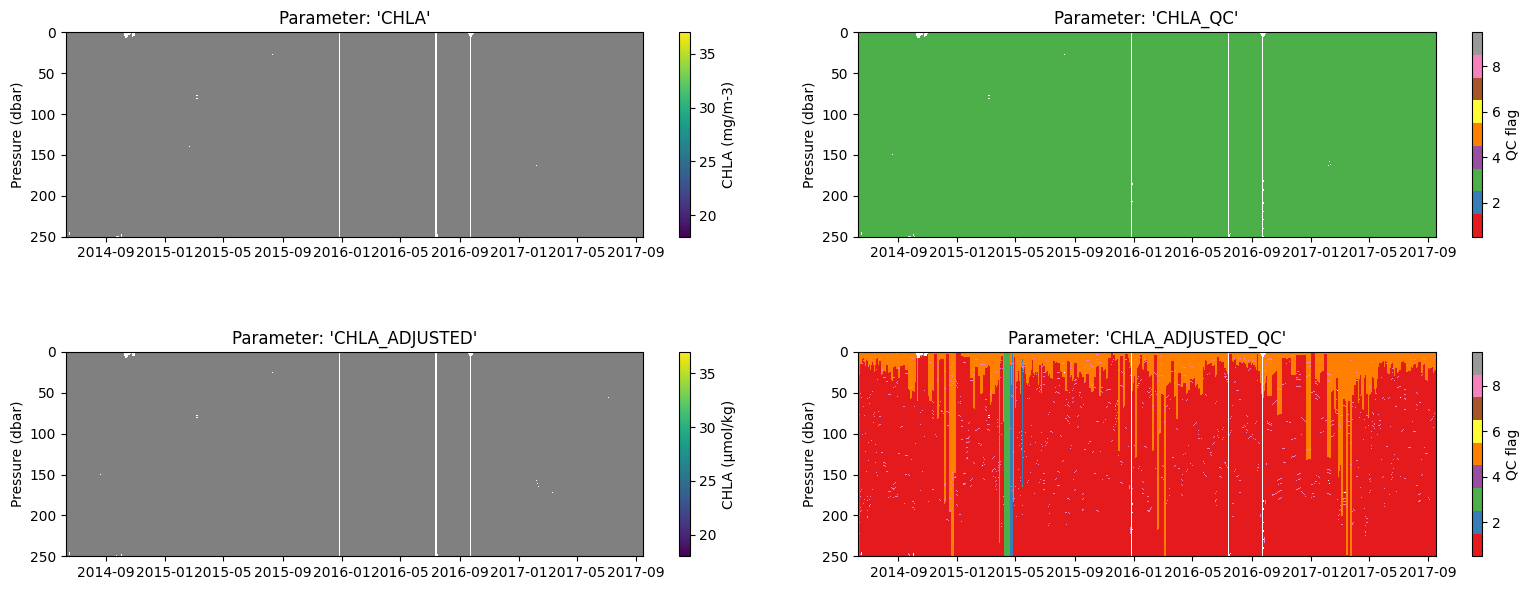

In [50]:
# Checking QC flags

# Stack NumPy array of datetimes to create a 2D grid
time_2D = np.tile(data['JULD'].values,(len(data['N_LEVELS']),1)).T

# Function for repetitive parts of plot
def config_depth_section(cbar_label,title):
  plt.ylim([0,250])
  plt.gca().invert_yaxis()
  plt.ylabel('Pressure (dbar)')
  if 'Nitrate' in cbar_label: extend = 'min'
  else:                       extend = 'neither'
  plt.colorbar(label=cbar_label,extend=extend)
  plt.title(title)

# Create subplots
plt.figure(figsize=(16,6))
plt.subplot(2,2,1)
cmap = plt.get_cmap('viridis')
cmap.set_under('0.5')
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA'].values,cmap=cmap,vmin=18,vmax=37)
config_depth_section('CHLA (mg/m-3)',"Parameter: 'CHLA'")

plt.subplot(2,2,2)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA_QC'].values.astype(float),cmap='Set1',vmin=0.5,vmax=9.5)
config_depth_section('QC flag',"Parameter: 'CHLA_QC'")

plt.subplot(2,2,3)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA_ADJUSTED'].values,cmap=cmap,vmin=18,vmax=37)
config_depth_section('CHLA (µmol/kg)',"Parameter: 'CHLA_ADJUSTED'")

plt.subplot(2,2,4)
plt.pcolor(time_2D,data['PRES_ADJUSTED'].values,data['CHLA_ADJUSTED_QC'].values.astype(float),cmap='Set1',vmin=0.5,vmax=9.5)
config_depth_section('QC flag',"Parameter: 'CHLA_ADJUSTED_QC'")

plt.tight_layout(h_pad=5,w_pad=3)

In [51]:
#Assesing Profile Number

display(data['PROF_NUM'].values)

len(data['PROF_NUM'].values)

data['PROF_NUM'].values[-1]


array([  1.,   1.,   2.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
        10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
        32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  44.,  45.,  45.,  46.,  46.,  47.,  47.,  48.,  48.,
        49.,  49.,  50.,  50.,  51.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
       101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111.,
       112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
       123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133.,
       134., 135., 136., 137., 138., 139., 140., 14

np.float64(357.0)

In [52]:
# Seperating profile by number

ice = data.sel(PROF_NUM=slice(None, 206))
ism = data.sel(PROF_NUM=slice(216, None))

In [53]:
# Function to convert an array from NumPy datetime64 to Python float format
def datetime_to_float(dt):
  return (dt - np.datetime64('1900-01-01')) / np.timedelta64(1,'D')

# Function to convert an array from Python float to NumPy datetime64 format
def float_to_datetime(nums):
  return (nums * np.timedelta64(1,'D')) + np.datetime64('1900-01-01')

# Function to interpolate data from a specified float parameter to a uniform time and pressure grid
def interpolate_depth_section(param_name,specify_qc_flags=None,pres_interval=1.0):
  """
  Arguments:
      param_name: string with netCDF file parameter name (e.g., 'TEMP_ADJUSTED') to interpolate
      specify_qc_flags: None to ignore QC flags
                        or a list of QC flags (e.g., [1,2,3]) indicating which data to retain before interpolation
      pres_interval: vertical resolution for interpolating pressure (z) axis (default: 1.0 dbar)
  
  Returns:
      time_coord: 1-D NumPy array with original profile timestamps in np.datetime64 format
      pres_coord: 1-D NumPy array with a uniform pressure (z) coordinate from 0 dbar to the deepest recorded
                  pressure value, at a resolution of <pres_interval> dbar
      time_grid: 2-D NumPy array with the meshed grid of time_coord
      pres_grid: 2-D NumPy array with the meshed grid of pres_coord
      param_gridded: 2-D NumPy array with the interpolated parameter values at the locations of time_grid and pres_grid

  """

  # New grid points
  time_coord = ice['JULD'].values
  pres_coord = np.arange(0,ice['PRES'].max(),pres_interval)
  time_grid, pres_grid = np.meshgrid(time_coord,pres_coord)
  time_grid = datetime_to_float(time_grid)     # Convert from np.datetime64 to float

  # 1-D (flattened) versions of old grids and parameter values
  time_1D = np.tile(ice['JULD'].values,(len(ice['N_LEVELS']),1)).T.flatten()
  pres_1D = ice['PRES'].values.flatten()
  param_1D = ice[param_name].values.flatten()
  if param_1D.dtype == object:         # If parameter is an array of QC flag data
    param_1D = param_1D.astype(float)  # Convert QC flags from dtype 'object' to float
    interp_method = 'nearest'          # Use nearest-neighbor interpolation for QC flags to avoid unwanted averaging
  else:
    interp_method = 'linear'           # Use bilinear interpolation for normal data fields

  # Extract only values matching specified QC flags
  if specify_qc_flags is not None:
    qc_1D = ice[param_name + '_QC'].values.astype(float).flatten()
    qc_mask = np.tile(False,len(qc_1D))
    for qc_flag in specify_qc_flags:
      qc_mask = np.logical_or(qc_mask,qc_1D == qc_flag)
    time_1D = time_1D[qc_mask]
    pres_1D = pres_1D[qc_mask]
    param_1D = param_1D[qc_mask]

  # Remove NaN values before interpolation
  time_1D = datetime_to_float(time_1D[~np.isnan(param_1D)])       # Convert from np.datetime64 to float
  pres_1D = pres_1D[~np.isnan(param_1D)]
  param_1D = param_1D[~np.isnan(param_1D)]

  # Interpolate from irregular points to grid
  param_gridded = interpolate.griddata((time_1D,pres_1D),param_1D,(time_grid,pres_grid),method=interp_method)

  # Return coordinates, grid, and gridded data
  return time_coord, pres_coord, float_to_datetime(time_grid), pres_grid, param_gridded

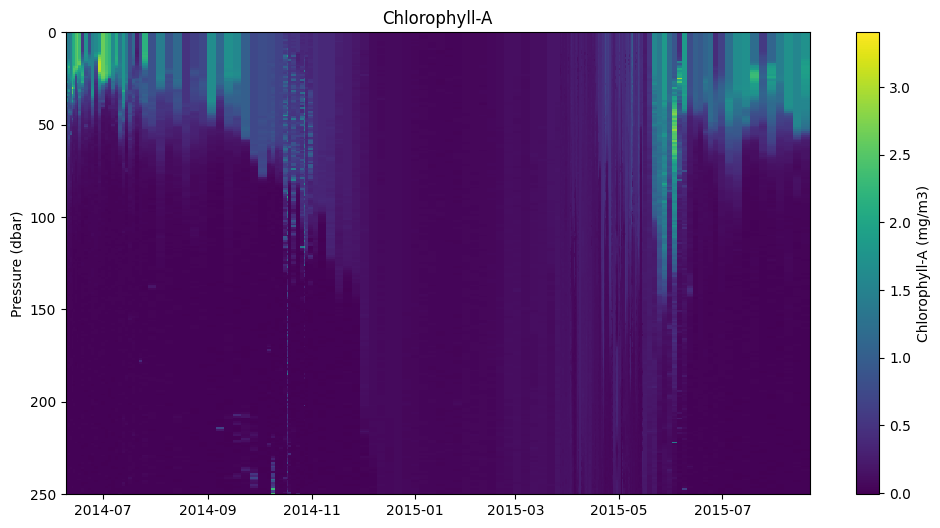

In [54]:
# Interpolate data
param_name = 'CHLA_ADJUSTED'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name);

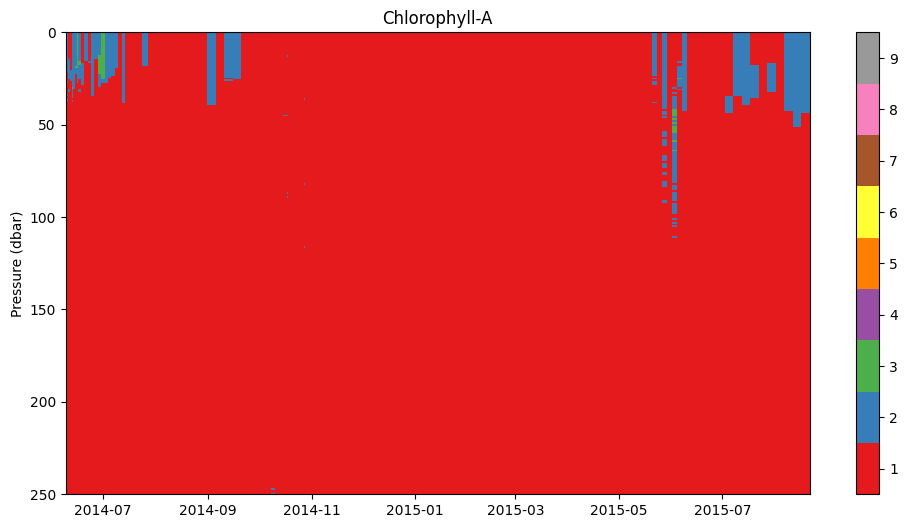

In [55]:
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded,cmap='Set1',vmin=0.5,vmax=9.5)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar()
plt.title(data[param_name].long_name);

In [56]:
# Function to convert an array from NumPy datetime64 to Python float format
def datetime_to_float(dt):
  return (dt - np.datetime64('1900-01-01')) / np.timedelta64(1,'D')

# Function to convert an array from Python float to NumPy datetime64 format
def float_to_datetime(nums):
  return (nums * np.timedelta64(1,'D')) + np.datetime64('1900-01-01')

# Function to interpolate data from a specified float parameter to a uniform time and pressure grid
def interpolate_depth_section(param_name,specify_qc_flags=None,pres_interval=1.0):
  """
  Arguments:
      param_name: string with netCDF file parameter name (e.g., 'TEMP_ADJUSTED') to interpolate
      specify_qc_flags: None to ignore QC flags
                        or a list of QC flags (e.g., [1,2,3]) indicating which data to retain before interpolation
      pres_interval: vertical resolution for interpolating pressure (z) axis (default: 1.0 dbar)
  
  Returns:
      time_coord: 1-D NumPy array with original profile timestamps in np.datetime64 format
      pres_coord: 1-D NumPy array with a uniform pressure (z) coordinate from 0 dbar to the deepest recorded
                  pressure value, at a resolution of <pres_interval> dbar
      time_grid: 2-D NumPy array with the meshed grid of time_coord
      pres_grid: 2-D NumPy array with the meshed grid of pres_coord
      param_gridded: 2-D NumPy array with the interpolated parameter values at the locations of time_grid and pres_grid

  """

  # New grid points
  time_coord = ism['JULD'].values
  pres_coord = np.arange(0,ism['PRES'].max(),pres_interval)
  time_grid, pres_grid = np.meshgrid(time_coord,pres_coord)
  time_grid = datetime_to_float(time_grid)     # Convert from np.datetime64 to float

  # 1-D (flattened) versions of old grids and parameter values
  time_1D = np.tile(ism['JULD'].values,(len(ism['N_LEVELS']),1)).T.flatten()
  pres_1D = ism['PRES'].values.flatten()
  param_1D = ism[param_name].values.flatten()
  if param_1D.dtype == object:         # If parameter is an array of QC flag data
    param_1D = param_1D.astype(float)  # Convert QC flags from dtype 'object' to float
    interp_method = 'nearest'          # Use nearest-neighbor interpolation for QC flags to avoid unwanted averaging
  else:
    interp_method = 'linear'           # Use bilinear interpolation for normal data fields

  # Extract only values matching specified QC flags
  if specify_qc_flags is not None:
    qc_1D = ism[param_name + '_QC'].values.astype(float).flatten()
    qc_mask = np.tile(False,len(qc_1D))
    for qc_flag in specify_qc_flags:
      qc_mask = np.logical_or(qc_mask,qc_1D == qc_flag)
    time_1D = time_1D[qc_mask]
    pres_1D = pres_1D[qc_mask]
    param_1D = param_1D[qc_mask]

  # Remove NaN values before interpolation
  time_1D = datetime_to_float(time_1D[~np.isnan(param_1D)])       # Convert from np.datetime64 to float
  pres_1D = pres_1D[~np.isnan(param_1D)]
  param_1D = param_1D[~np.isnan(param_1D)]

  # Interpolate from irregular points to grid
  param_gridded = interpolate.griddata((time_1D,pres_1D),param_1D,(time_grid,pres_grid),method=interp_method)

  # Return coordinates, grid, and gridded data
  return time_coord, pres_coord, float_to_datetime(time_grid), pres_grid, param_gridded

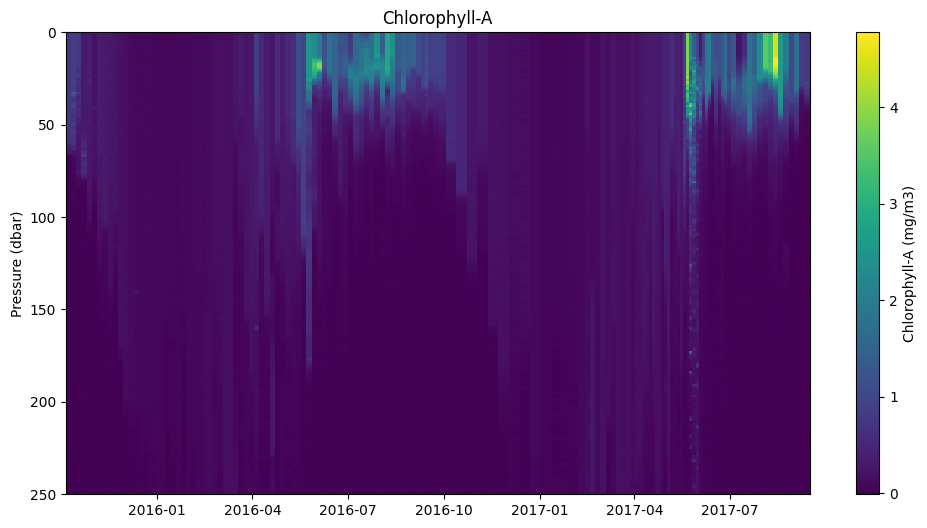

In [57]:
# Interpolate data
param_name = 'CHLA_ADJUSTED'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name);

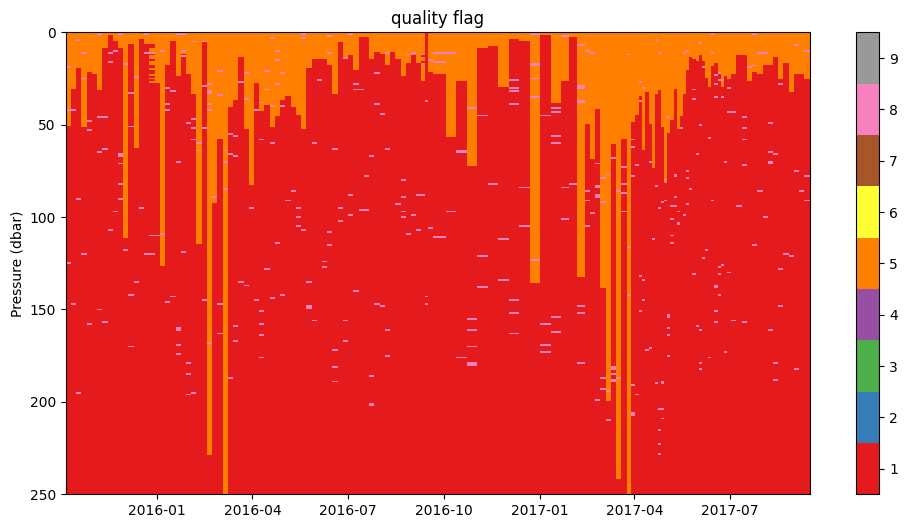

In [58]:
# Interpolate data
param_name = 'CHLA_ADJUSTED_QC'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded,cmap='Set1',vmin=0.5,vmax=9.5)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar()
plt.title(data[param_name].long_name);

## Downloading Large Dataset